<a href="https://colab.research.google.com/github/ansariwaleed/MNE_documentation_implementation/blob/main/Overview_of_artifact_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.0 MB/s eta 0:00:00


In [5]:
import os

import numpy as np

import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(0, 60).load_data()  # just use a fraction of data for speed here

Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.09TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 01m37s (1576.2 MB)
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

In [6]:
#Artifact detection
ssp_projectors = raw.info["projs"]
raw.del_proj()

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

Using matplotlib as 2D backend.


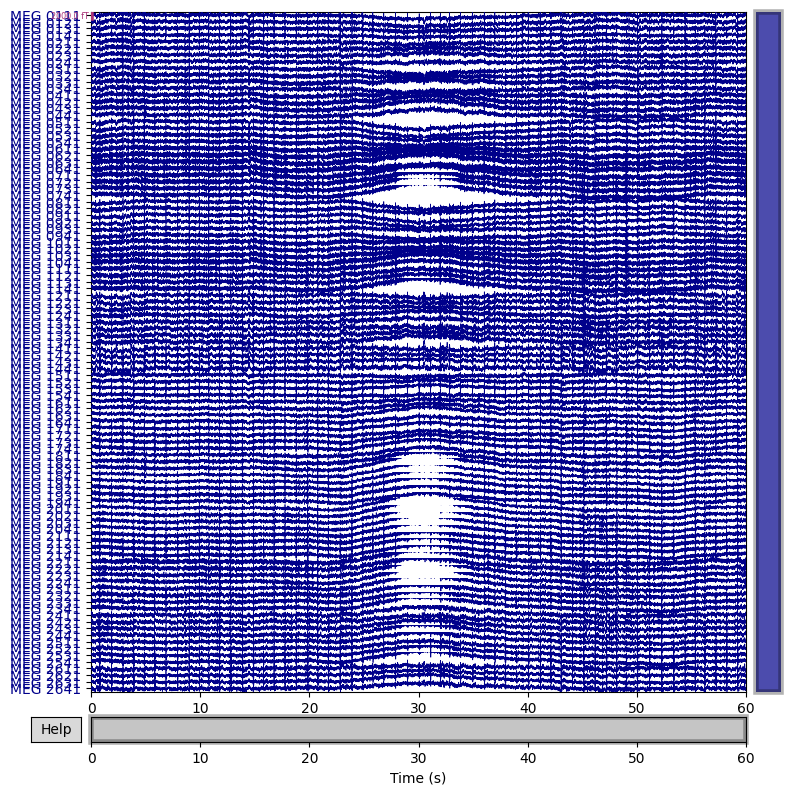

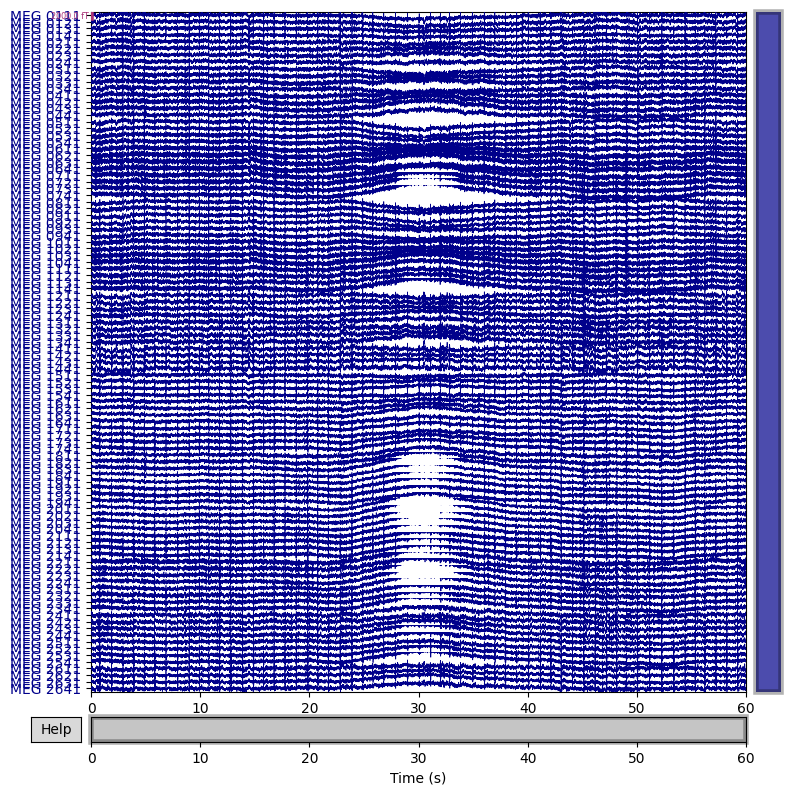

In [7]:
mag_channels = mne.pick_types(raw.info, meg="mag")
raw.plot(duration=60, order=mag_channels, n_channels=len(mag_channels), remove_dc=False)

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


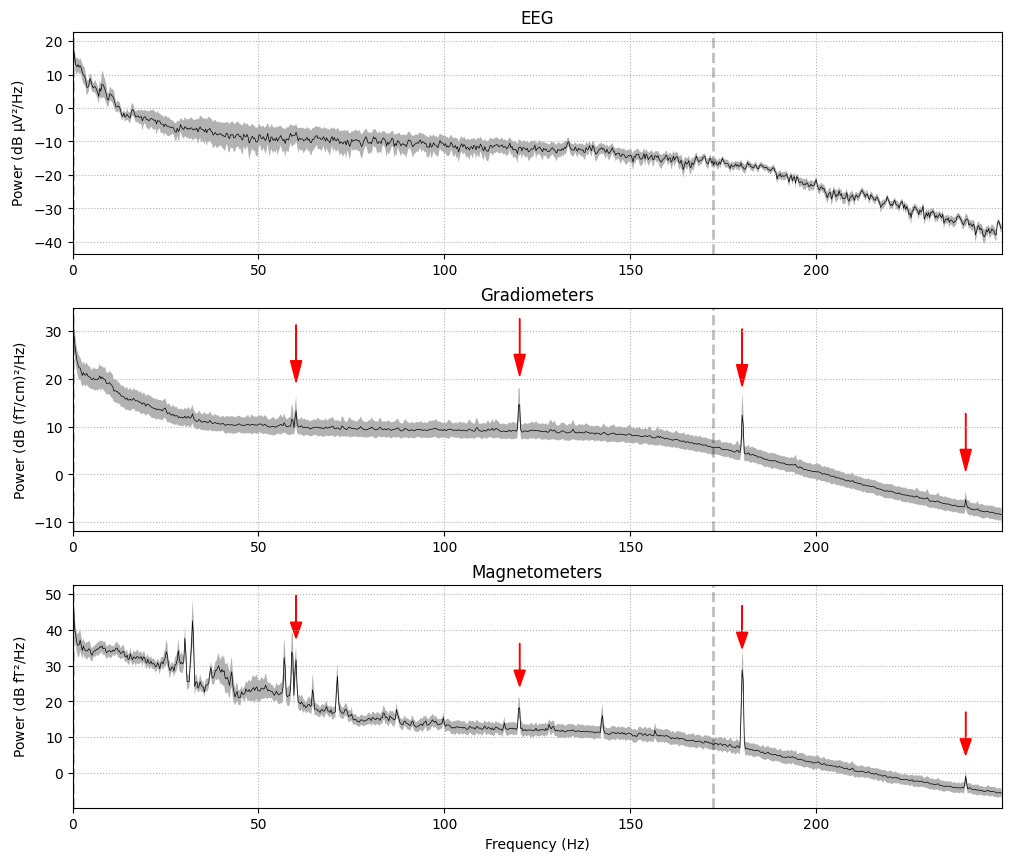

In [8]:
#power line noise
fig = raw.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 s)

Number of ECG events detected : 59 (average pulse 58.9981981638739 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Using data from preloaded Raw for 59 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not sett

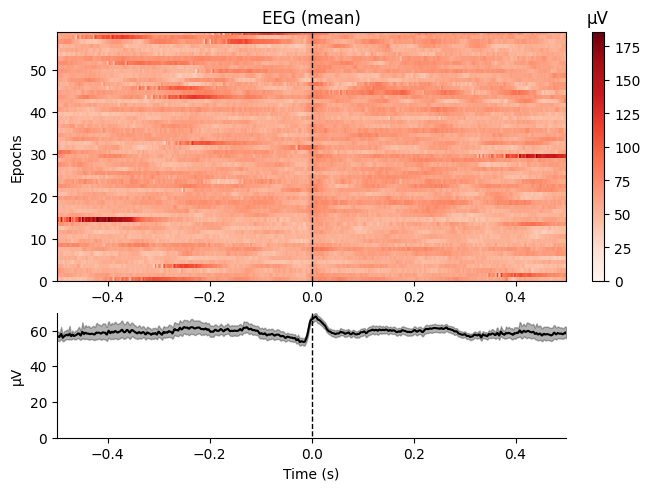

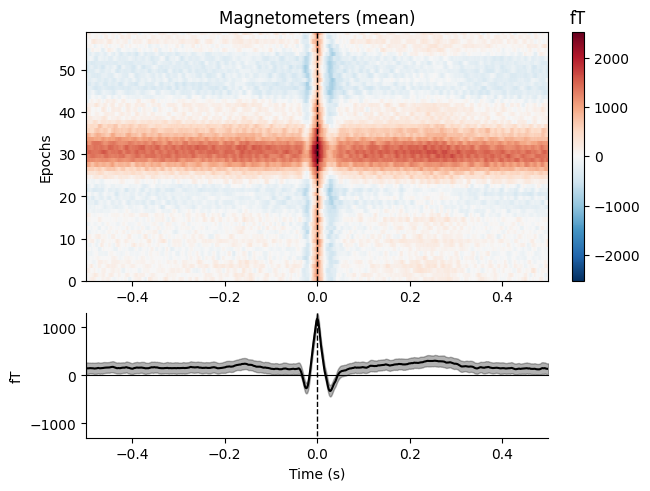

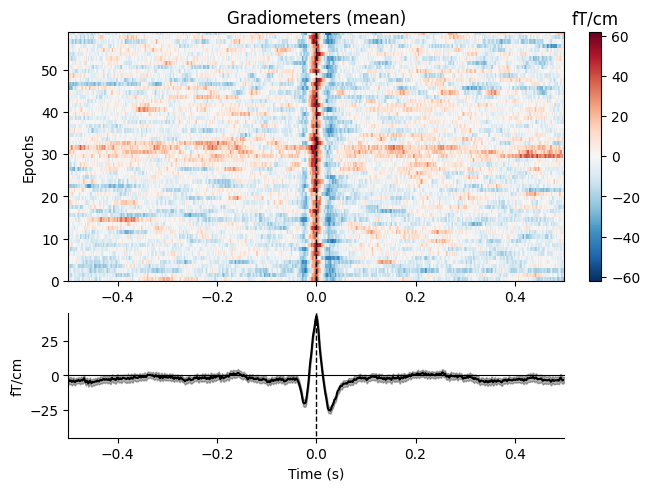

[<Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>]

In [9]:
#Heartbeat artifacts (ECG)
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine="mean")

In [10]:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))

Applying baseline correction (mode: mean)


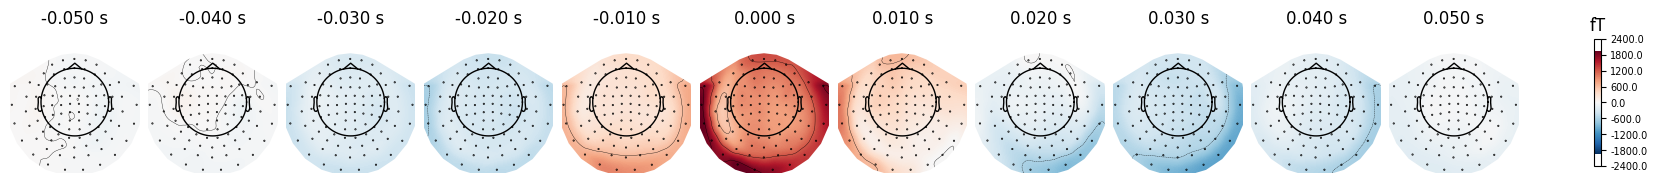

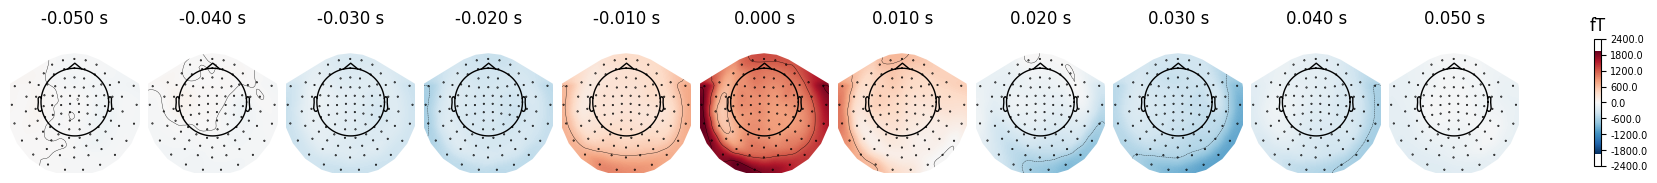

In [11]:
avg_ecg_epochs.plot_topomap(times=np.linspace(-0.05, 0.05, 11))

No projector specified for this dataset. Please consider the method self.add_proj.


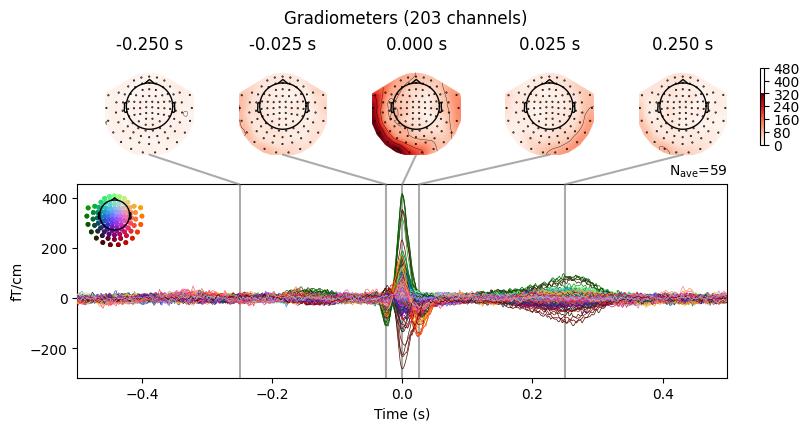

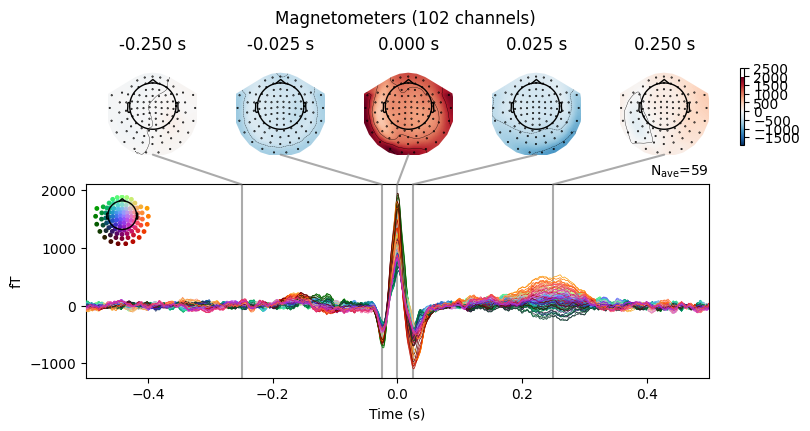

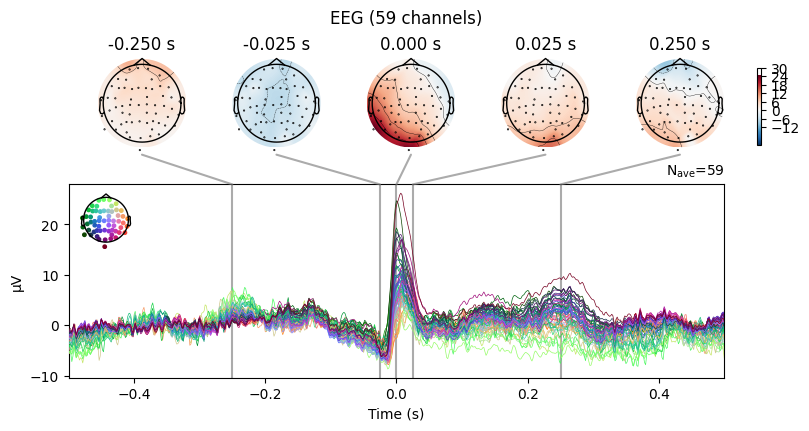

[<Figure size 800x420 with 8 Axes>,
 <Figure size 800x420 with 8 Axes>,
 <Figure size 800x420 with 8 Axes>]

In [12]:
avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 10 events and 601 original time points ...
0 bad epochs dropped
Not setting m

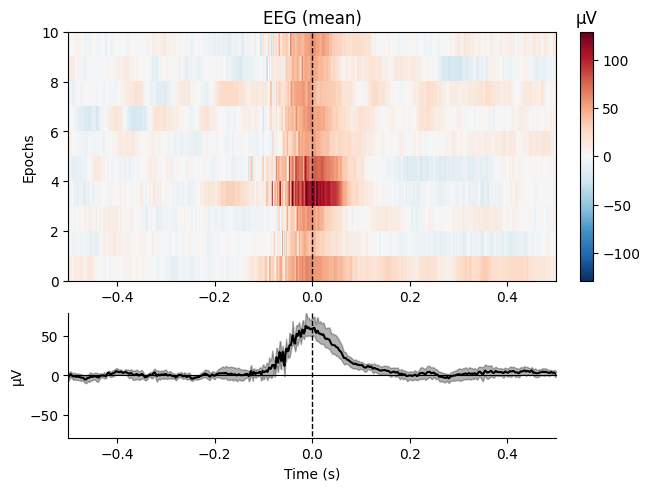

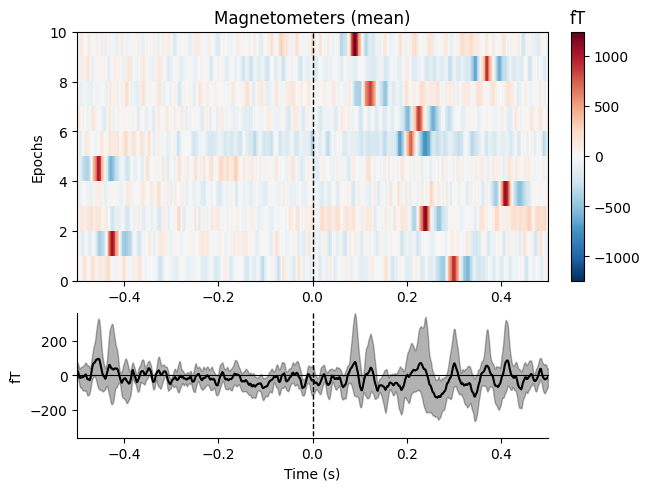

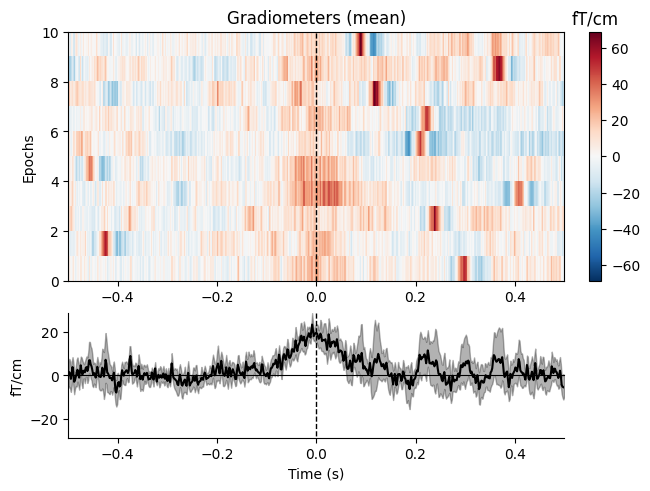

No projector specified for this dataset. Please consider the method self.add_proj.


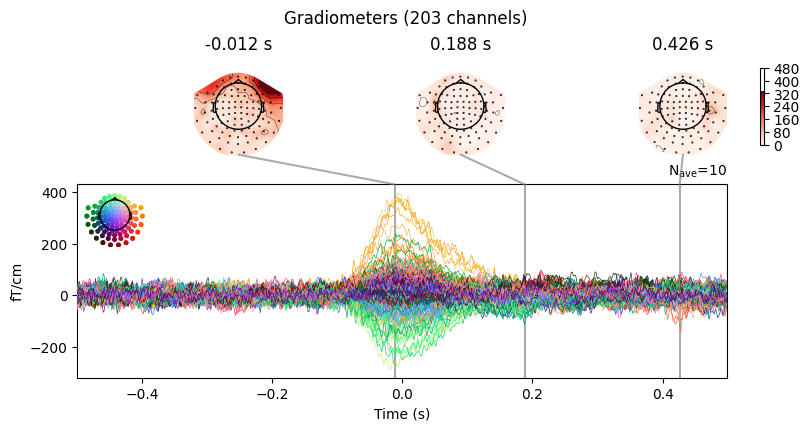

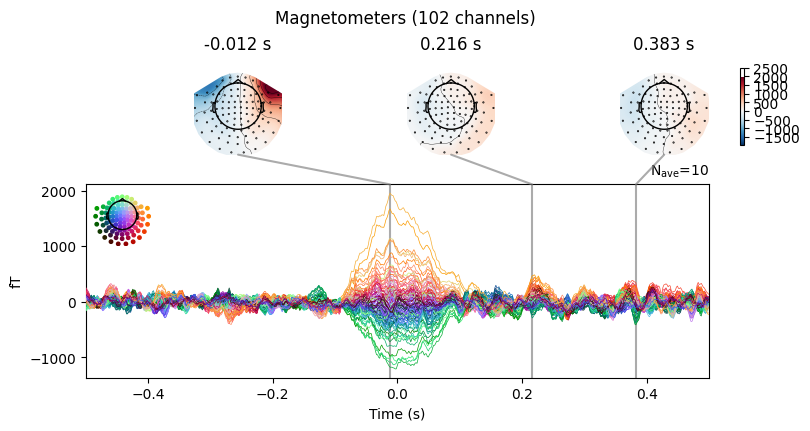

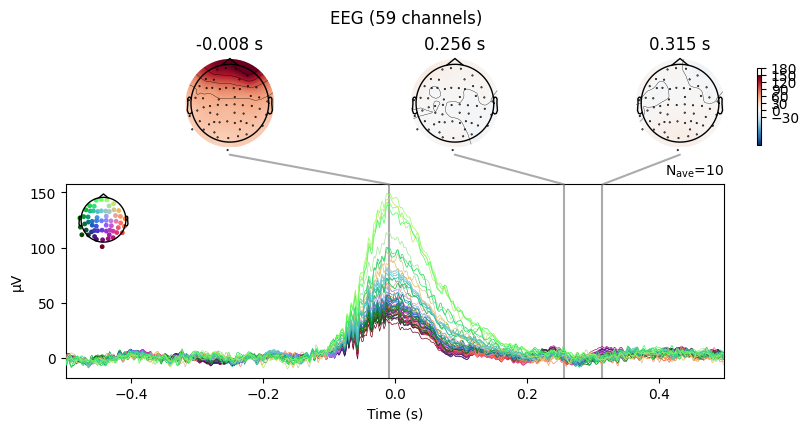

[<Figure size 800x420 with 6 Axes>,
 <Figure size 800x420 with 6 Axes>,
 <Figure size 800x420 with 6 Axes>]

In [13]:
#Ocular asrifacts(EOG)
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine="mean")
eog_epochs.average().plot_joint()